In [177]:
import sys
sys.path.append('..\\helpers')

import cv2
import random
import os
import matplotlib.pyplot as plt
import numpy as np
from loguru import logger
import pandas as pd
import seaborn as sns
from PIL import Image, ImageDraw
from functools import reduce

from pywt import dwt2
import math
from scipy import ndimage


# From helpers directory
from preprocessing import Preprocessor
from morphological_sifter import MorphologicalSifter
import display


preprocessor = Preprocessor()
mms = MorphologicalSifter()

plt.rcParams['figure.figsize'] = (20, 18)
plt.style.use('classic')
plt.subplots_adjust(wspace=0, hspace=0)
sns.set()

# To allow auto reload to this notebook after modifying any external file imported
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 640x480 with 0 Axes>

In [155]:
dataset_folder_paths = [(x[0].split("\\")[-1], x[0]) for x in os.walk("..\\dataset")][1:]
dataset_folder_paths

[('groundtruth', '..\\dataset\\groundtruth'),
 ('images', '..\\dataset\\images'),
 ('masks', '..\\dataset\\masks'),
 ('overlay', '..\\dataset\\overlay'),
 ('processed', '..\\dataset\\processed'),
 ('images', '..\\dataset\\processed\\images'),
 ('overlay', '..\\dataset\\processed\\overlay')]

In [172]:
def Morphological_sifter(M1, M2, orientation, image, breast_mask):
    # Create a copy of the input image
    newimage = np.copy(image)
    
    # Get the dimensions of the input image
    m, n = newimage.shape
    
    ## Border effect control: border padding
    # Option 1: pad with highest pixel value
    temp = np.full((m+4*M1, n+4*M1), 65535, dtype=np.uint16)
    temp[2*M1:(2*M1+m), 2*M1:(2*M1+n)] = newimage
    
    ## Apply multi-scale morphological sifting
    enhanced_image = np.zeros_like(temp)
    for k in range(len(orientation)):
        B1 = cv2.getStructuringElement(cv2.MORPH_RECT, (M1, 1), (-1, -1))
        B2 = cv2.getStructuringElement(cv2.MORPH_RECT, (M2, 1), (-1, -1))
        bg1 = cv2.morphologyEx(temp, cv2.MORPH_OPEN, B1)
        r1 = cv2.subtract(temp, bg1)
        r2 = cv2.morphologyEx(r1, cv2.MORPH_OPEN, B2)
        enhanced_image = enhanced_image + r2.astype(np.float64)

    enhanced_image = enhanced_image[2*M1:2*M1+m, 2*M1:2*M1+n] # Reset the image into the original size

    enhanced_image = (enhanced_image-enhanced_image.min())/(enhanced_image.max()-enhanced_image.min())*255
    enhanced_image = enhanced_image.astype(np.uint8)
    enhanced_image = cv2.bitwise_and(enhanced_image, enhanced_image, mask=breast_mask.astype(np.uint8))
    
    return enhanced_image

def linear_structuring_elements(Num_scale, D, type):
    """
    This function generates the length of the linear structuring elements (LSE) 
    used in morphological filter elements on different scales. Either linear or 
    logarithmic scale interval is used.

    INPUT:
    Num_scale : int : The number of scales used
    D : list : The diameter range of breast masses
    type : str : The scale type (linear or logarithmic)

    OUTPUT:
    len_bank : numpy.ndarray : The magnitudes of the LSEs
    """
    if type == 'linear':
        scale_interval = int((D[1] - D[0]) / Num_scale)
        len_bank = np.zeros(Num_scale + 1, dtype=int)
        for l in range(Num_scale + 1):
            len_bank[l] = D[0] + (l - 1) * scale_interval
        len_bank[Num_scale] = D[1]

    if type == 'exponential':
        scale_interval = (D[1] / D[0]) ** (1 / Num_scale)
        len_bank = np.zeros(Num_scale + 1, dtype=int)
        for l in range(Num_scale + 1):
            len_bank[l] = int(D[0] * (scale_interval ** (l - 1)))
        len_bank[Num_scale] = D[1]

    return len_bank

def Normalization_mask(image, mask, mode):
    # Convert image to double
    image = np.double(image)
    
    # Compute intensity values within the mask
    inten = image[mask == 1]
    
    # Compute minimum and maximum intensity values
    mini = np.min(inten)
    maxi = np.max(inten)
    
    # Normalize image
    image = (image - mini) / abs(maxi - mini)
    
    # Zero out values outside the mask
    image[mask < 1] = 0
    
    # Convert image to the desired mode
    if mode == 8:
        new_im = (image * 255).astype(np.uint8)
    elif mode == 16:
        new_im = (image * 65535).astype(np.uint16)
    elif mode == 'double':
        new_im = image
    else:
        raise ValueError('Invalid mode')
    
    return new_im


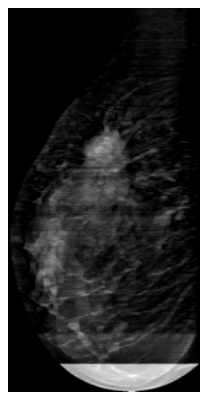

In [173]:
# img_name = '20587612_f4b2d377f43ba0bd_MG_R_CC_ANON.tif'
img_name = '22613822_45c7f44839fd9e68_MG_R_ML_ANON.tif'

img_path = os.path.join(dataset_folder_paths[4][1], 'images',img_name)
image = cv2.imread(img_path)

area_min = 15
area_max = 3689
mass_size_range = [area_min, area_max] # square mm

pixel_size = 0.07 # spatial resolution of the INbreast mammograms, 0.07mm

resize_factor = 4
resize_ratio = 1 / resize_factor

n_scale = 2

n_lse_elements = 18

mass_diameter_range_pixel = [math.floor((mass_size_range[0]/math.pi)**0.5*2/(pixel_size/resize_ratio)),
                             math.ceil((mass_size_range[1]/math.pi)**0.5*2/(pixel_size/resize_ratio))] # diameter range in pixels


lse = linear_structuring_elements(n_scale, mass_diameter_range_pixel, 'exponential')
angle_range = list(range(0, 190, n_lse_elements))


image = image[:,:,0]
breast_mask = (image > 0)
(cA, _) = dwt2(image, 'db2')
(image, _) = dwt2(cA, 'db2')

(cA, _) = dwt2(breast_mask, 'db2')
(breast_mask, _) = dwt2(cA, 'db2')
breast_mask = (breast_mask >= 1)

new_im = Normalization_mask(image,breast_mask,8);

# Loop across all images
enhanced_image = []

for j in range(1, n_scale+1):
    enhanced_image.append(Morphological_sifter(lse[j], lse[j-1], angle_range, new_im, breast_mask))


# Pseudo_color_im = np.dstack((new_im, enhanced_image[0], enhanced_image[1]))


enhanced_image = np.sum(enhanced_image, axis=0)

# enhanced_image = cv2.normalize(enhanced_image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

# Grayscale normalization
# max_pixel_value = np.max(enhanced_image)
# if max_pixel_value > 0:
#     enhanced_image = (enhanced_image / max_pixel_value) * 255

# otsu_threshold, binary_image = cv2.threshold(enhanced_image.astype('uint8'), 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    
plt.axis('off')
plt.imshow(enhanced_image, cmap='gray')
plt.show()

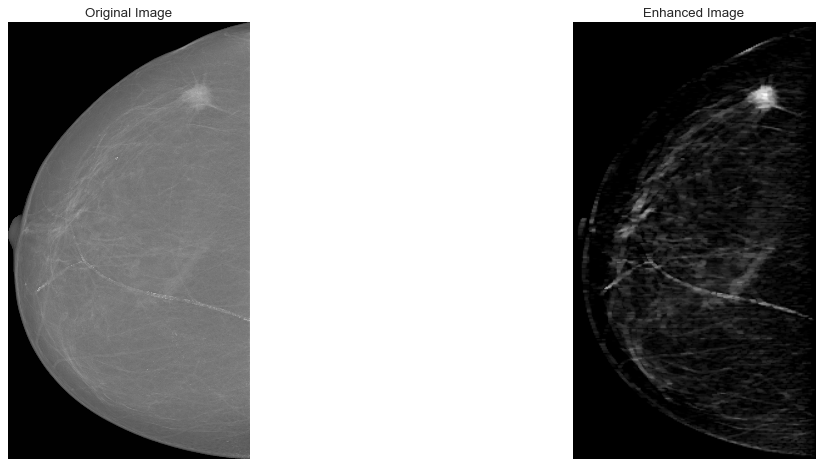

In [185]:
# Moved the code to a class
img_name = '20587612_f4b2d377f43ba0bd_MG_R_CC_ANON.tif'

img_path = os.path.join(dataset_folder_paths[4][1], 'images',img_name)
image = cv2.imread(img_path)

mms.fit(image, plot=True)

#### KEEP THE CODE BELOW FOR REFERENCE, DON'T MODIFY

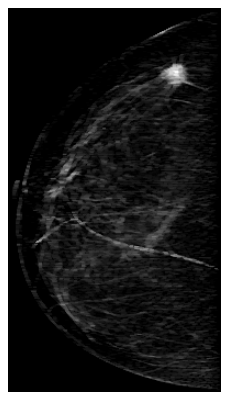

In [186]:
def Morphological_sifter(M1, M2, orientation, image, L_or_R, padding_option, breast_mask):
    # Create a copy of the input image
    newimage = np.copy(image)
    
    # Get the dimensions of the input image
    m, n = newimage.shape
    
    ## Border effect control: border padding
    # Option 1: pad with highest pixel value
    temp = np.full((m+4*M1, n+4*M1), 65535, dtype=np.uint16)
#     temp[2*M1:2*M1+m, 2*M1:2*M1+n] = newimage
    temp[2*M1:(2*M1+m), 2*M1:(2*M1+n)] = newimage

    
    # Option 2: replicate the pixels on the border
    if padding_option == 1:
        if L_or_R == 1: # left breast
            edge = newimage[:, :min(n, 2*M1)]
            temp[2*M1:2*M1+m, 2*M1-edge.shape[1]:2*M1] = np.fliplr(edge)
        else: # right breast
            edge = newimage[:, max(0, n-2*M1):n]
            temp[2*M1:2*M1+m, n+2*M1:n+2*M1+edge.shape[1]] = np.fliplr(edge)
    
    ## Apply multi-scale morphological sifting
    enhanced_image = np.zeros_like(temp)
    for k in range(len(orientation)):
        B1 = cv2.getStructuringElement(cv2.MORPH_RECT, (M1, 1), (-1, -1))
#         B1 = cv2.warpAffine(B1, cv2.getRotationMatrix2D((M1/2, M1/2), orientation[k], 1), (M1, M1))   
        
        B2 = cv2.getStructuringElement(cv2.MORPH_RECT, (M2, 1), (-1, -1))
#         B2 = cv2.warpAffine(B2, cv2.getRotationMatrix2D((M2/2, M2/2), orientation[k], 1), (M2, M2))
        
        bg1 = cv2.morphologyEx(temp, cv2.MORPH_OPEN, B1)
        r1 = cv2.subtract(temp, bg1)
        r2 = cv2.morphologyEx(r1, cv2.MORPH_OPEN, B2)
        enhanced_image = enhanced_image + r2

    
    enhanced_image = enhanced_image[2*M1:2*M1+m, 2*M1:2*M1+n] # Reset the image into the original size
#     enhanced_image = Normalization_mask(enhanced_image,breast_mask,8);
    enhanced_image = (enhanced_image-enhanced_image.min())/(enhanced_image.max()-enhanced_image.min())*255
    enhanced_image = enhanced_image.astype(np.uint8)
    enhanced_image = cv2.bitwise_and(enhanced_image, enhanced_image, mask=breast_mask.astype(np.uint8))

#     enhanced_image = cv2.normalize(enhanced_image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
#     enhanced_image = cv2.bitwise_and(enhanced_image, enhanced_image, mask=breast_mask.astype(np.uint8))
    
    return enhanced_image

def linear_structuring_elements(Num_scale, D, type):
    """
    This function generates the length of the linear structuring elements (LSE) 
    used in morphological filter elements on different scales. Either linear or 
    logarithmic scale interval is used.

    INPUT:
    Num_scale : int : The number of scales used
    D : list : The diameter range of breast masses
    type : str : The scale type (linear or logarithmic)

    OUTPUT:
    len_bank : numpy.ndarray : The magnitudes of the LSEs
    """
    if type == 'linear':
        scale_interval = int((D[1] - D[0]) / Num_scale)
        len_bank = np.zeros(Num_scale + 1, dtype=int)
        for l in range(Num_scale + 1):
            len_bank[l] = D[0] + (l - 1) * scale_interval
        len_bank[Num_scale] = D[1]

    if type == 'exponential':
        scale_interval = (D[1] / D[0]) ** (1 / Num_scale)
        len_bank = np.zeros(Num_scale + 1, dtype=int)
        for l in range(Num_scale + 1):
            len_bank[l] = int(D[0] * (scale_interval ** (l - 1)))
        len_bank[Num_scale] = D[1]

    return len_bank

def Normalization_mask(image, mask, mode):
    # Convert image to double
    image = np.double(image)
    
    # Compute intensity values within the mask
    inten = image[mask == 1]
    
    # Compute minimum and maximum intensity values
    mini = np.min(inten)
    maxi = np.max(inten)
    
    # Normalize image
    image = (image - mini) / abs(maxi - mini)
    
    # Zero out values outside the mask
    image[mask < 1] = 0
    
    # Convert image to the desired mode
    if mode == 8:
        new_im = (image * 255).astype(np.uint8)
    elif mode == 16:
        new_im = (image * 65535).astype(np.uint16)
    elif mode == 'double':
        new_im = image
    else:
        raise ValueError('Invalid mode')
    
    return new_im

img_name = '20587612_f4b2d377f43ba0bd_MG_R_CC_ANON.tif'
# img_name = '22613822_45c7f44839fd9e68_MG_R_ML_ANON.tif'

img_path = os.path.join(dataset_folder_paths[4][1], 'images',img_name)
image = cv2.imread(img_path)

area_min = 15
area_max = 3689
mass_size_range = [area_min, area_max] # square mm

pixel_size = 0.07 # spatial resolution of the INbreast mammograms, 0.07mm

resize_factor = 4
resize_ratio = 1 / resize_factor

n_scale = 2

n_lse_elements = 18

mass_diameter_range_pixel = [math.floor((mass_size_range[0]/math.pi)**0.5*2/(pixel_size/resize_ratio)),
                             math.ceil((mass_size_range[1]/math.pi)**0.5*2/(pixel_size/resize_ratio))] # diameter range in pixels


lse = linear_structuring_elements(n_scale, mass_diameter_range_pixel, 'exponential')
angle_range = list(range(0, 190, n_lse_elements))


image = image[:,:,0]
breast_mask = (image > 0)
(cA, _) = dwt2(image, 'db2')
(image, _) = dwt2(cA, 'db2')

(cA, _) = dwt2(breast_mask, 'db2')
(breast_mask, _) = dwt2(cA, 'db2')
breast_mask = (breast_mask >= 1)

new_im = Normalization_mask(image,breast_mask,8);

CC_OR_ML = 1 if '_CC_' in img_name else 0
L_OR_R = 1 if '_L_' in img_name else 0

# Loop across all images
enhanced_image = []

for j in range(1, n_scale+1):
    # Boundary padding
    padding_mode = 1
    if j == 1 or CC_OR_ML == 1:
        # if it is a small scale or it is a MLO view
        padding_mode = 0  # highest value padding
    enhanced_image.append(Morphological_sifter(lse[j], lse[j-1], angle_range, new_im, L_OR_R, padding_mode, breast_mask))


# Pseudo_color_im = np.dstack((new_im, enhanced_image[0], enhanced_image[1]))


enhanced_image = np.sum(enhanced_image, axis=0)

# enhanced_image = cv2.normalize(enhanced_image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

# Grayscale normalization
# max_pixel_value = np.max(enhanced_image)
# if max_pixel_value > 0:
#     enhanced_image = (enhanced_image / max_pixel_value) * 255

# otsu_threshold, binary_image = cv2.threshold(enhanced_image.astype('uint8'), 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    
plt.axis('off')
plt.imshow(enhanced_image, cmap='gray')
plt.show()